In [1]:
import numpy as np
import pandas as pd
import yaml
import os
import pickle

# Dataloading

In [2]:
# Read filename of wells with DTS
with open("/home/geouser05/geo/conf/parameters.yml", 'r') as stream:
    parameters = yaml.safe_load(stream)

In [3]:
raw_filenames = parameters['filename_dts']
def process_filename(x):
    return x.replace('/', '_').replace(' ', '_') + '_logs.las'

# Format filenames
filenames = [process_filename(x) for x in raw_filenames]

In [4]:
# Read data that contains the model inputs and target variable
df_input = pd.read_csv('/home/geouser05/geo/data/02_preprocessed/well_logs.csv')
df_input2 = pd.read_csv('/home/geouser05/geo/data/02_preprocessed/well_logs2.csv')

In [5]:
# Check if filenames are missing
for f in filenames:
    if  f not in df_input.filename.unique():
        print(f)

In [7]:
# Filter dataframe for the relevant filenames (wells) for training and testing
df_filter = df_input[df_input.filename.isin(filenames)].iloc[:, 1:].copy()

# Data Preprocessing

In [169]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px

In [11]:

features_base = [
            # 'CALI', 
            # 'DRHO', 
            'DTC', 
            # 'FORCE_2020_LITHOFACIES_CONFIDENCE', 
            #'FORCE_2020_LITHOFACIES_LITHOLOGY',
            'GR', 
            'NPHI', 
            # 'PEF', 
            #'RDEP', 
            'RHOB', 
            #'RMED', 
            # 'ROP',
            # 'RSHA', 
            # 'RXO', 
            # 'SP', 
            # 'RMIC', 
            # 'SGR', 
            # 'ROPA', 
            # 'DCAL',
            # 'MUDWEIGHT'
            ]
features_one_hot_encode = ['FORCE_2020_LITHOFACIES_LITHOLOGY']
features_scale = ['GR', 'NPHI', 'DTC',  'RHOB'] #list(set(features_base) - set(features_one_hot_encode))
target = 'DTS'
target_clf = 'DTS_BOOL'
n = 50

In [20]:
# Prepare target variable for classification model
df_filter['DTS_BOOL'] = ~df_filter['DTS'].isna()
df_filter = df_filter.fillna(np.nan)

In [21]:
# Split well for train and test
test_idx = [ 3, 22,  5, 33, 35,  0, 20,  5]
train_idx = list(set(range(len(filenames))) - set(test_idx))

# Create train and test dataframes
def get_filename(df, f_list, idx_list):
    f_list = [x for i, x in enumerate(f_list) if i in idx_list]
    return df[df.filename.isin(f_list)].copy()

df_train = get_filename(df_filter, filenames, train_idx)
df_test = get_filename(df_filter, filenames, test_idx)

In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [23]:
if True:
    scaler = StandardScaler()
    scaler.fit(df_train[features_scale])

    with open('/home/geouser05/geo/data/06_model/scale.pkl', 'wb') as file:
        pickle.dump(scaler, file)
else:
    with open('/home/geouser05/geo/data/06_model/onehot_encoder.pkl', 'rb') as file:
        enc = pickle.load(file)
    encoded_columns = list(enc.categories_[0])[:-1]

    with open('/home/geouser05/geo/data/06_model/scale.pkl', 'rb') as file:
        scaler = pickle.load(file)
    
    
features = features_scale #+ encoded_columns
n_features = len(features) + 1

In [24]:
#df_train[encoded_columns] = enc.transform(df_train[features_one_hot_encode])[:,:-1]
df_train[features_scale] = scaler.transform(df_train[features_scale])

#df_test[encoded_columns] = enc.transform(df_test[features_one_hot_encode])[:,:-1]
df_test[features_scale] = scaler.transform(df_test[features_scale])

# Model Training

In [35]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [170]:
metrics = []

In [26]:
# Create train and test dataframe where DTS is available
df_train_dts = df_train[df_train.DTS_BOOL]
df_test_dts = df_test[df_test.DTS_BOOL]

In [27]:
# Classification model
clf = LGBMClassifier()
clf.fit(df_train[features], df_train[target_clf])
y_pred_train = clf.predict(df_train[features])
score_train = f1_score(df_train[target_clf], y_pred_train)

y_pred_test = clf.predict(df_test[features])
score_test = f1_score(df_test[target_clf], y_pred_test)

print(score_train, score_test)


0.8855117576701413 0.8512739054701672


In [172]:
# Regression Model
params = [{},
          dict(objective = 'quantile', alpha = 1 - 0.975),
          dict(objective = 'quantile', alpha = 0.975)]
reg_list = []
for param in params:
    reg = LGBMRegressor(**param)
    print(reg)
    reg.fit(df_train_dts[features], df_train_dts[target])
    y_pred_train = reg.predict(df_train_dts[features])
    score_train = mean_squared_error(df_train_dts[target], y_pred_train)
    score_abs_train = mean_absolute_error(df_train_dts[target], y_pred_train)
    r2_score_train = r2_score(df_train_dts[target], y_pred_train)

    y_pred_test = reg.predict(df_test_dts[features])
    score_test = mean_squared_error(df_test_dts[target], y_pred_test)
    score_abs_test = mean_absolute_error(df_test_dts[target], y_pred_train)
    r2_score_test = r2_score(df_test_dts[target], y_pred_test)

    reg_list.append(reg)

    print(score_train ** 0.5, score_test ** 0.5)
    print(r2_score_train, r2_score_test)

    metrics.append(['LGBM', score_train ** 0.5, score_test ** 0.5, score_abs_train, score_abs_test, r2_score_train, r2_score_test])
    print()

LGBMRegressor()


ValueError: Found input variables with inconsistent numbers of samples: [51012, 254017]

# Missing data imputation

In [109]:
df_full = df_input.copy()
df_full['field'] = 'Force'
df_full2 = df_input2.copy()
print(df_full.shape, df_full2.shape)
df_full = pd.concat((df_full, df_full2), axis = 0)
df_full['DTS_BOOL'] = ~df_full['DTS'].isna()

(2137884, 29) (75202, 28)


In [110]:
df_full.field.unique()

array(['Force', 'Pesidon'], dtype=object)

In [111]:
#df_full[encoded_columns] = enc.transform(df_full[features_one_hot_encode])[:,:-1]
df_full[features_scale] = scaler.transform(df_full[features_scale])

In [112]:
df_full['DTS_BOOL_PRED'] = clf.predict(df_full[features])

In [113]:
for reg_name, reg in zip(['', '_025', '_975'], reg_list):
    df_full[f'DTS_PRED{reg_name}'] = reg.predict(df_full[features])

## MICE

In [114]:
imp = IterativeImputer(estimator=LinearRegression(),random_state=0)
imp.fit(df_train_dts[[target] + features])

IterativeImputer(estimator=LinearRegression(), random_state=0)

In [115]:
imputed_columns = [str(x) + '_PRED_MICE' for x in [target] + features]

In [116]:
df_full[imputed_columns] = imp.transform(df_full[[target] + features])

## MICE + LGBM

In [117]:
imp2 = IterativeImputer(estimator=LinearRegression(),random_state=0)
imp2.fit(df_train_dts[ features])

/appdrive/mambaforge/envs/py37_tensorflow/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


IterativeImputer(estimator=LinearRegression(), random_state=0)

In [118]:
imputed_columns2 = [str(x) + '_PRED_MICE_2' for x in features]

In [119]:
df_full[imputed_columns2] = imp2.transform(df_full[features])
df_train_dts[imputed_columns2] = imp2.transform(df_train_dts[features])
df_test_dts[imputed_columns2] = imp2.transform(df_test_dts[features])

/appdrive/mambaforge/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/appdrive/mambaforge/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [173]:
# Regression Model
params = [{},
          dict(objective = 'quantile', alpha = 1 - 0.975),
          dict(objective = 'quantile', alpha = 0.975)]
reg_list2 = []
for param in params:
    reg = LGBMRegressor(**param)
    print(reg)
    reg.fit(df_train_dts[imputed_columns2], df_train_dts[target])
    y_pred_train = reg.predict(df_train_dts[imputed_columns2])
    score_train = mean_squared_error(df_train_dts[target], y_pred_train)
    score_abs_train = mean_absolute_error(df_train_dts[target], y_pred_train)
    r2_score_train = r2_score(df_train_dts[target], y_pred_train)

    y_pred_test = reg.predict(df_test_dts[imputed_columns2])
    score_test = mean_squared_error(df_test_dts[target], y_pred_test)
    score_abs_test = mean_absolute_error(df_train_dts[target], y_pred_test)
    r2_score_test = r2_score(df_test_dts[target], y_pred_test)

    reg_list2.append(reg)
    metrics.append(['MICE+LGBM', score_train ** 0.5, score_test ** 0.5, score_abs_train, score_abs_test, r2_score_train, r2_score_test])

    print(score_train ** 0.5, score_test ** 0.5)
    print(r2_score_train, r2_score_test)
    print()

LGBMRegressor()


NameError: name 'score_abs_test' is not defined

In [121]:
for reg_name, reg in zip(['', '_025', '_975'], reg_list2):
    df_full[f'DTS_PRED_MICE2_LGBM{reg_name}'] = reg.predict(df_full[features])

In [122]:
# Save to csv

In [167]:
df_full['field'] = [x.replace('Pesidon', 'Poseidon') for x in df_full['field'] ]
print(df_full['field'].unique())
df_full.to_csv('/home/geouser05/geo/data/07_model_output/prediction_dts_full2.csv')

['Force' 'Poseidon']


In [86]:
df_full.shape

(2213086, 66)

# Plot stuff

In [124]:
from lightgbm import plot_importance

In [140]:
df_1 = pd.DataFrame([reg_list[0].feature_name_, reg_list[0].feature_importances_], index = ['feature', 'importance']).T
df_1['type'] = 'selected'

In [134]:
features_all = [
            #'CALI', 
            'DRHO', 
            'DTC', 
            # 'FORCE_2020_LITHOFACIES_CONFIDENCE', 
            'FORCE_2020_LITHOFACIES_LITHOLOGY',
            'GR', 
            'NPHI', 
            #'PEF', 
            'RDEP', 
            'RHOB', 
            'RMED', 
            'ROP',
            'RSHA', 
            'RXO', 
            'SP', 
            'RMIC', 
            'SGR', 
            'ROPA', 
            #'DCAL',
            #'MUDWEIGHT'
            ]

In [135]:
reg = LGBMRegressor()
print(reg)
reg.fit(df_train_dts[features_all], df_train_dts[target])
y_pred_train = reg.predict(df_train_dts[features_all])
score_train = mean_squared_error(df_train_dts[target], y_pred_train)
r2_score_train = r2_score(df_train_dts[target], y_pred_train)

y_pred_test = reg.predict(df_test_dts[features_all])
score_test = mean_squared_error(df_test_dts[target], y_pred_test)
r2_score_test = r2_score(df_test_dts[target], y_pred_test)

print(score_train ** 0.5, score_test ** 0.5)
print(r2_score_train, r2_score_test)

LGBMRegressor()
15.78885218218881 20.794492681973303
0.9583977009468657 0.850788524470432


In [161]:
df_2 = pd.DataFrame([reg.feature_name_, reg.feature_importances_], index = ['feature', 'importance']).T
df_2['type'] = 'all features'
df_2 = df_2.sort_values('importance', ascending = False)
df_imp = pd.concat((df_2, df_1), axis = 0)
df_imp .to_csv('/home/geouser05/geo/data/08_report/feature_importance.csv', index = False)

In [162]:
df_imp['feature'] = [f.replace('FORCE_2020_LITHOFACIES_LITHOLOGY', 'LIT') for f in df_imp['feature']]

In [166]:
fig = px.bar(df_imp, x = 'feature', y = 'importance', color = 'type', barmode = 'group', width = 700, height = 500, title = 'Feature Importances')
fig.update_layout(yaxis = dict(showticklabels=  False))
fig.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

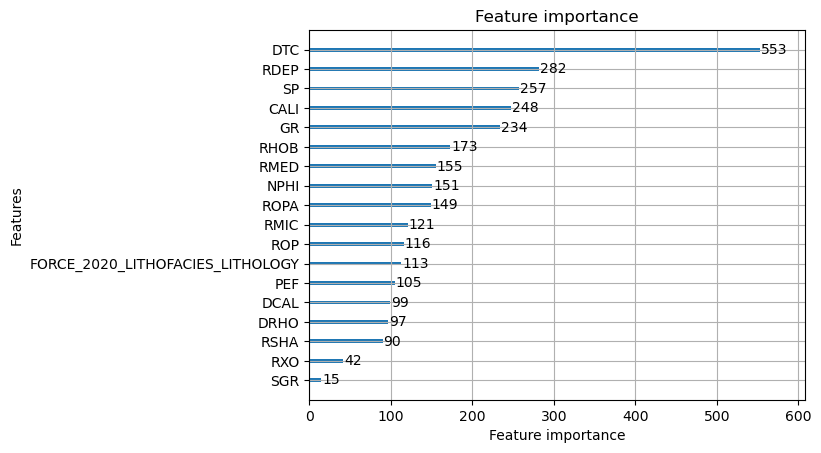

In [131]:
plot_importance(reg)